In [2]:
import torch
import torch.nn as nn

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size

        # Define the LSTM cell
        self.lstm_cell = nn.Linear(input_size + hidden_size, hidden_size * 4)

        # Define the output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self,inputs):
        sequence_length = inputs.shape[1]
        batch_size = inputs.shape[0]
        
        outputs = torch.zeros(batch_size,sequence_length,self.output_size)
        hidden_state = torch.zeros(batch_size,self.hidden_size)
        
        for i in range(sequence_length):
            temp_op, hidden_state = self.inner_loop(inputs[:,i],hidden_state)
            outputs[:,i] = temp_op
            
        return outputs

    def inner_loop(self, inputs, hidden_state):
        combined = torch.cat((inputs, hidden_state), dim=1)
        lstm_output = self.lstm_cell(combined)

        # Split the LSTM output into gates
        input_gate, forget_gate, cell_state, output_gate = torch.split(lstm_output, self.hidden_size, dim=1)

        # Apply activation functions
        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_state = torch.tanh(cell_state)
        output_gate = torch.sigmoid(output_gate)

        # Update the cell state
        cell_state = forget_gate * cell_state + input_gate * torch.tanh(cell_state)

        # Compute the hidden state
        hidden_state = output_gate * torch.tanh(cell_state)

        # Compute the output
        output = self.output_layer(hidden_state)

        return output, hidden_state

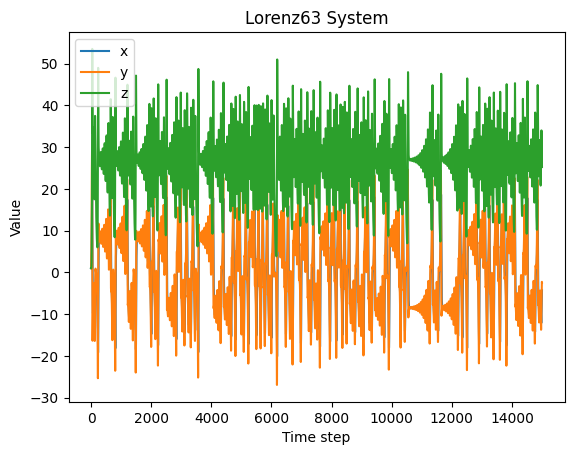

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def lorenz63(x, y, z, sigma, rho, beta):
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return dx, dy, dz

def simulate_lorenz63(sigma, rho, beta, x0, y0, z0, dt, num_steps):
    # Initialize arrays to store the simulation results
    xs = np.zeros(num_steps)
    ys = np.zeros(num_steps)
    zs = np.zeros(num_steps)

    # Set initial conditions
    xs[0] = x0
    ys[0] = y0
    zs[0] = z0

    # Simulate the system
    for i in range(1, num_steps):
        dx, dy, dz = lorenz63(xs[i-1], ys[i-1], zs[i-1], sigma, rho, beta)
        xs[i] = xs[i-1] + dt * dx
        ys[i] = ys[i-1] + dt * dy
        zs[i] = zs[i-1] + dt * dz

    return xs, ys, zs

# Set the parameters
sigma = 10.0
rho = 28.0
beta = 8.0/3.0

# Set the initial conditions
x0 = 1.0
y0 = 1.0
z0 = 1.0

# Set the time step and number of steps
dt = 0.01
num_steps = 15000

# Simulate the Lorenz63 system
xs, ys, zs = simulate_lorenz63(sigma, rho, beta, x0, y0, z0, dt, num_steps)

# Plot the results
plt.figure()
plt.plot(xs, label='x')
plt.plot(ys, label='y')
plt.plot(zs, label='z')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Lorenz63 System')
plt.show()

trajectory = np.asarray([xs,ys,zs]).T[:10000]
test_trajectory = np.asarray([xs,ys,zs]).T[10000:]

In [4]:
# Define the parameters
input_size = 3  # From Lorenz
hidden_size = 128  # Number of units in the hidden state
output_size = 3  # From Lorenz

# Create the LSTM model
model = LSTM(input_size, hidden_size, output_size)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-2*seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+2*seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x).astype('float32'),np.array(y).astype('float32')

In [6]:
# Define the input and target sequences
import numpy as np
x_data, y_data = sliding_windows(trajectory,10)

x_data = torch.tensor(x_data)
y_data = torch.tensor(y_data)

In [7]:
# Train the model
num_epochs = 2000
total_samples = x_data.shape[0]
batch_size = 128

for epoch in range(num_epochs):
    # Subselect batches
    ii = 0
    while (ii*batch_size) < total_samples:
        
        x_ = x_data[ii*batch_size:(ii+1)*batch_size]
        y_ = y_data[ii*batch_size:(ii+1)*batch_size]
    
        outputs = model(x_)
        # obtain the loss function
        loss = criterion(outputs, y_)
        ii = ii + 1
        
        optimizer.zero_grad()
        loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 302.54938
Epoch: 10, loss: 278.53546
Epoch: 20, loss: 252.44382
Epoch: 30, loss: 222.94179
Epoch: 40, loss: 194.90985
Epoch: 50, loss: 171.28873
Epoch: 60, loss: 151.71671
Epoch: 70, loss: 135.05661
Epoch: 80, loss: 120.86156
Epoch: 90, loss: 108.73208
Epoch: 100, loss: 98.21300
Epoch: 110, loss: 88.98221
Epoch: 120, loss: 80.84506
Epoch: 130, loss: 73.64872
Epoch: 140, loss: 67.35210
Epoch: 150, loss: 61.70532
Epoch: 160, loss: 56.69385
Epoch: 170, loss: 52.27160
Epoch: 180, loss: 48.25415
Epoch: 190, loss: 44.64447
Epoch: 200, loss: 41.35416
Epoch: 210, loss: 38.47774
Epoch: 220, loss: 35.92285
Epoch: 230, loss: 33.68520
Epoch: 240, loss: 31.69309
Epoch: 250, loss: 29.86806
Epoch: 260, loss: 28.08427
Epoch: 270, loss: 26.49109
Epoch: 280, loss: 25.04703
Epoch: 290, loss: 23.66045
Epoch: 300, loss: 22.40255
Epoch: 310, loss: 21.23196
Epoch: 320, loss: 20.16416
Epoch: 330, loss: 19.13126
Epoch: 340, loss: 18.13685
Epoch: 350, loss: 17.26468
Epoch: 360, loss: 16.47342
Ep

KeyboardInterrupt: 

In [8]:
def sliding_windows_rollout(data, seq_length):
    x = []
    y = []
    
    ii = 0
    while ii+2*seq_length < np.shape(data)[0]:
        _x = data[ii:(ii+seq_length)]
        _y = data[ii+seq_length:ii+2*seq_length]
        
        x.append(_x)
        y.append(_y)
        
        ii = ii + seq_length

    return np.array(x).astype('float32'),np.array(y).astype('float32')

# Define the input and target sequences
x_data_t, y_data_t = sliding_windows_rollout(test_trajectory,10)

x_data_t = torch.tensor(x_data_t)
y_data_t = torch.tensor(y_data_t)

In [9]:
pred_data_t = []

x_input = x_data_t[0:1]
for i in range(x_data_t.size()[0]):
    outputs = model(x_input)
    
    pred_data_t.append(outputs.detach().numpy())
    
    x_input = outputs
    
pred_data_t = np.asarray(pred_data_t)[:,0]

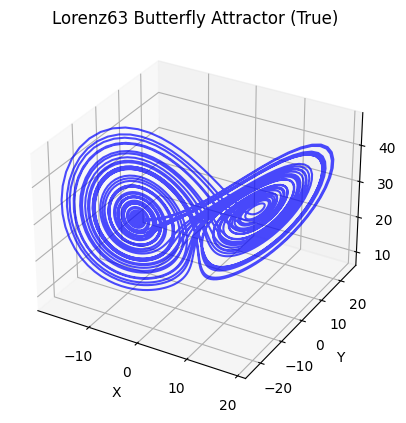

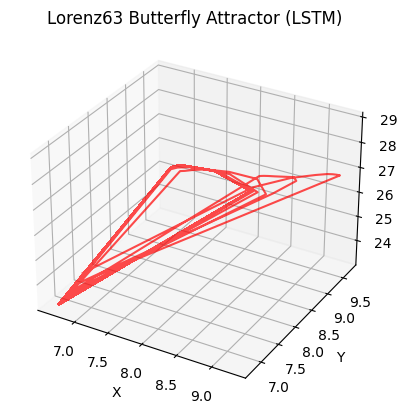

In [13]:
def visualize_trajectory(true_data,pred_data):
    assert true_data.shape == pred_data.shape
    
    true_data = true_data.reshape(-1,3)
    pred_data = pred_data.reshape(-1,3)
    
    # Plot the butterfly attractor
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(true_data[:,0], true_data[:,1], true_data[:,2], alpha=0.7, color='blue')
#     ax.plot(pred_data[:,0], pred_data[:,1], pred_data[:,2], alpha=0.7, color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Lorenz63 Butterfly Attractor (True)')
    plt.show()

    # Plot the butterfly attractor
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     ax.plot(true_data[:,0], true_data[:,1], true_data[:,2], alpha=0.7, color='blue')
    ax.plot(pred_data[:,0], pred_data[:,1], pred_data[:,2], alpha=0.7, color='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Lorenz63 Butterfly Attractor (LSTM)')
    plt.show()


visualize_trajectory(y_data_t.numpy(),pred_data_t)